# Dataset

In [59]:
from sklearn import cluster, datasets, mixture
import numpy as np
import matplotlib.pyplot as plt

noisy_moons=datasets.make_moons(n_samples=500, noise=0.11)

# Fit normal distribution for each class

<ipython-input-60-d0a357dbc541>:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data[:, 0], data[:, 1], s=10, cmap='viridis')


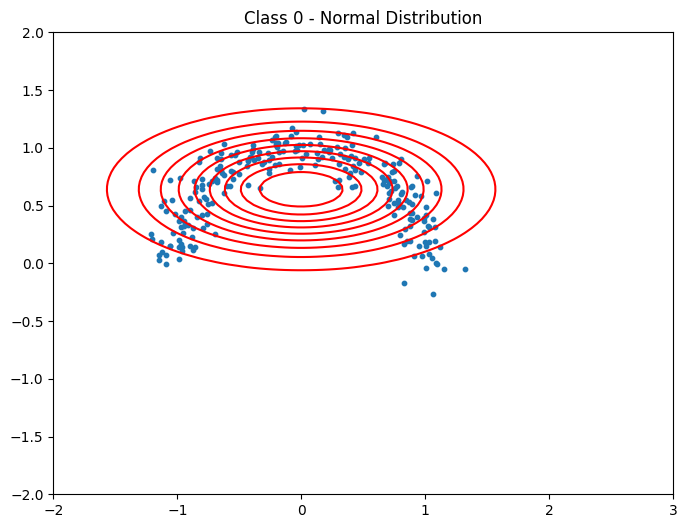

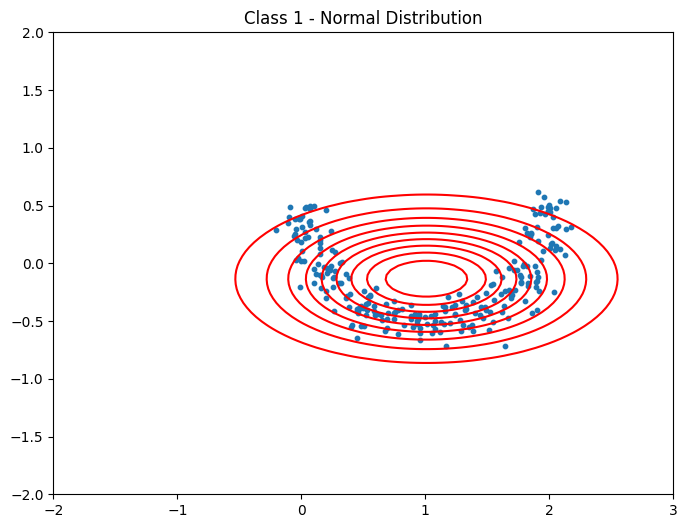

In [60]:
def fit_and_plot_normal(data, title):
    mean, std = np.mean(data, axis=0), np.std(data, axis=0)
    x, y = np.meshgrid(np.linspace(-2, 3, 100), np.linspace(-2, 2, 100))
    density = np.exp(-0.5 * ((x - mean[0]) ** 2 / std[0] ** 2 + (y - mean[1]) ** 2 / std[1] ** 2))

    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], s=10, cmap='viridis')
    plt.contour(x, y, density, levels=10, colors='r')
    plt.title(title)
    plt.show()

fit_and_plot_normal(noisy_moons[0][noisy_moons[1] == 0], 'Class 0 - Normal Distribution')
fit_and_plot_normal(noisy_moons[0][noisy_moons[1] == 1], 'Class 1 - Normal Distribution')

# GMM class

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

class GMM:
    def __init__(self, n_components, max_iter=100, tol=1e-4):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.weights = None
        self.means = None
        self.covariances = None

    def fit(self, X):
        n_samples, n_features = X.shape

        # Initialize parameters
        self.weights = np.ones(self.n_components) / self.n_components
        self.means = X[np.random.choice(n_samples, self.n_components, replace=False)]
        self.covariances = [np.cov(X.T) for _ in range(self.n_components)]

        # Initialize old parameters for convergence checking
        self.old_weights = np.zeros(self.n_components)
        self.old_means = np.zeros_like(self.means)
        self.old_covariances = [np.zeros_like(cov) for cov in self.covariances]

        # EM algorithm
        for _ in range(self.max_iter):
            # E-step
            responsibilities = self._calculate_responsibilities(X)

            # M-step
            self._update_parameters(X, responsibilities)

            # Check for convergence
            if self._converged():
                break

        del self.old_weights
        del self.old_means
        del self.old_covariances

    def _calculate_responsibilities(self, X):
        responsibilities = np.zeros((X.shape[0], self.n_components))

        for i in range(self.n_components):
            distribution = multivariate_normal(self.means[i], self.covariances[i])
            responsibilities[:, i] = self.weights[i] * distribution.pdf(X)

        # Normalize responsibilities
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)

        return responsibilities

    def _update_parameters(self, X, responsibilities, reg=1e-6):
        # Update weights
        self.weights = responsibilities.mean(axis=0)

        # Update means
        self.means = responsibilities.T @ X / responsibilities.sum(axis=0)[:, np.newaxis]

        # Update covariances with regularization ( to make the cov matrix positive definitive)
        for i in range(self.n_components):
            diff = X - self.means[i]
            covariance = (responsibilities[:, i, np.newaxis] * diff).T @ diff / responsibilities[:, i].sum()
            self.covariances[i] = covariance + reg * np.eye(X.shape[1])

    def _converged(self):
        return (
            np.all(np.abs(self.weights - self.old_weights) < self.tol) and
            all(np.all(np.abs(self.means[i] - self.old_means[i]) < self.tol) for i in range(self.n_components)) and
            all(np.all(np.abs(self.covariances[i] - self.old_covariances[i]) < self.tol) for i in range(self.n_components))
        )

    def predict(self, X):
        responsibilities = self._calculate_responsibilities(X)
        return np.argmax(responsibilities, axis=1)


# Plotting GMM contours for n=1,3,8,16

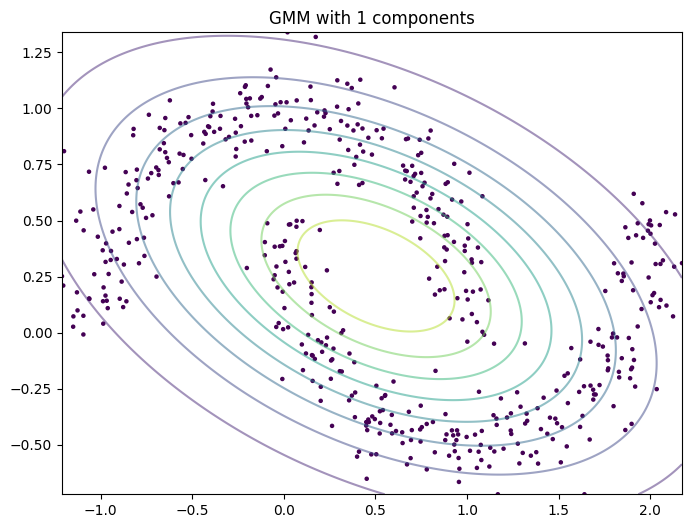

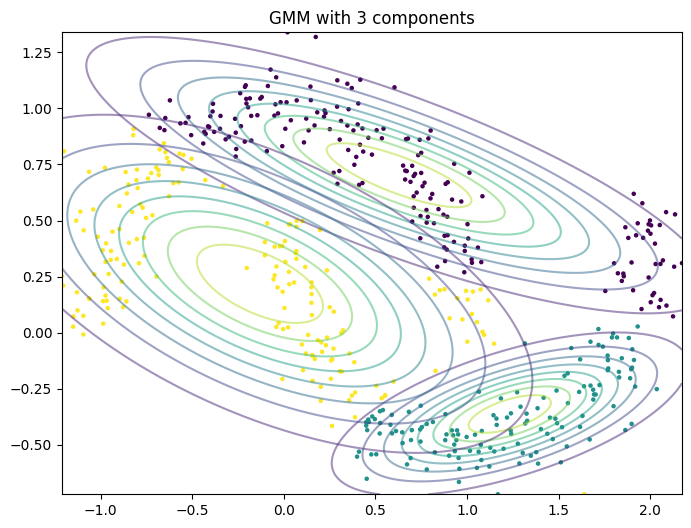

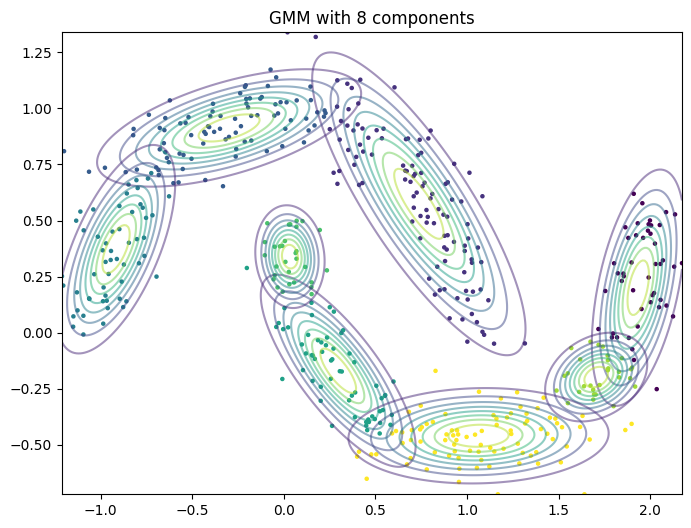

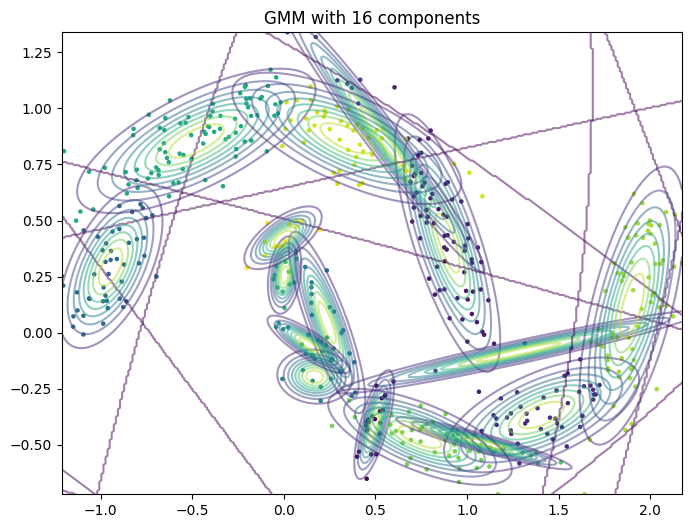

In [64]:
X = noisy_moons[0]
num_components_list = [1, 3, 8, 16]
for num_components in num_components_list:
    gmm = GMM(n_components=num_components)
    gmm.fit(X)

    # Plot the results
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=gmm.predict(X), cmap='viridis', s=5)

    for i in range(num_components):
        distribution = multivariate_normal(gmm.means[i], gmm.covariances[i])

        x_min, x_max = X[:, 0].min(), X[:, 0].max()
        y_min, y_max = X[:, 1].min(), X[:, 1].max()

        x, y = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
        pos = np.dstack((x, y))

        levels = np.linspace(0, distribution.pdf(gmm.means[i]), 10)

        plt.contour(x, y, distribution.pdf(pos), levels=levels, alpha=0.5)

    plt.title(f'GMM with {num_components} components')
    plt.show()

# Finding optimal component number ( using sklearn )

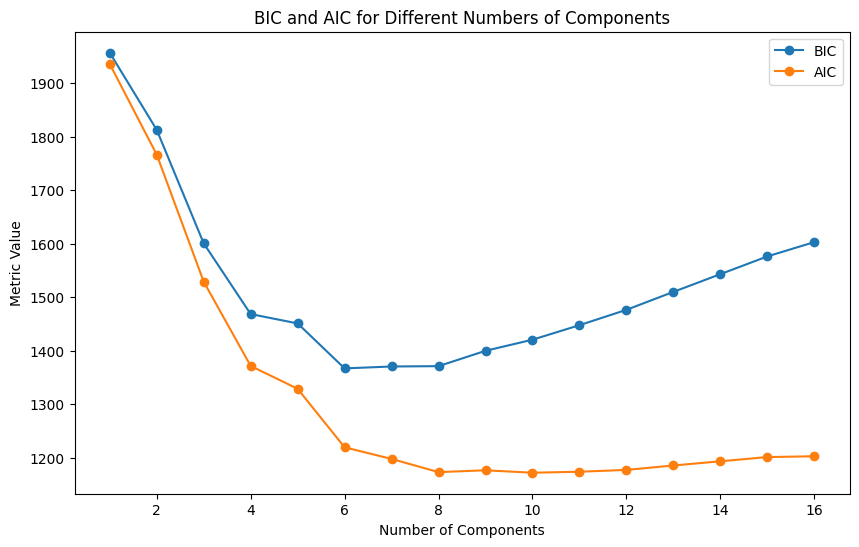

Optimal number of components based on BIC: 6
Optimal number of components based on AIC: 10


In [66]:
import numpy as np
from sklearn import datasets, mixture
import matplotlib.pyplot as plt


num_components_list = range(1, 17)
bic_values = []
aic_values = []

for num_components in num_components_list:
    gmm = mixture.GaussianMixture(n_components=num_components)
    gmm.fit(X)

    bic = gmm.bic(X)
    aic = gmm.aic(X)

    bic_values.append(bic)
    aic_values.append(aic)

# Plot BIC and AIC values
plt.figure(figsize=(10, 6))
plt.plot(num_components_list, bic_values, label='BIC', marker='o')
plt.plot(num_components_list, aic_values, label='AIC', marker='o')
plt.title('BIC and AIC for Different Numbers of Components')
plt.xlabel('Number of Components')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

# Find the optimal number of components based on BIC and AIC
optimal_components_bic = num_components_list[np.argmin(bic_values)]
optimal_components_aic = num_components_list[np.argmin(aic_values)]

print(f'Optimal number of components based on BIC: {optimal_components_bic}')
print(f'Optimal number of components based on AIC: {optimal_components_aic}')